<a href="https://colab.research.google.com/github/budur1/ML-projects/blob/main/deep_Learning_EMNIST_Classifier_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task: Train an EMNIST classifier

EMNIST (or extended MNIST) is just like MNIST, a bunch of handwritten images, except instead of just digits (0-9) it also has uppercase and lowercase characters.

You are provided with the code to load the EMNIST train and split **datasets**

Write and train a classifier for EMNIST. Make sure to

- Show how your loss(es) dropped during training.
- Show final performance of your model on untrained data.
- Maintain good code quality.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as pd

import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision.datasets import EMNIST
import torchvision.transforms.functional as F
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

In [2]:
train_data = EMNIST(root='emnist_data/', split='byclass', download=True)
test_data = EMNIST(root='emnist_data/', split='byclass', download=True, train=False)

100%|██████████| 561753746/561753746 [00:08<00:00, 69585123.32it/s]


Extracting emnist_data/EMNIST/raw/gzip.zip to emnist_data/EMNIST/raw


In [3]:
train_data

Dataset EMNIST
    Number of datapoints: 697932
    Root location: emnist_data/
    Split: Train

Number of classes in dataset: 62
Unique labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
7


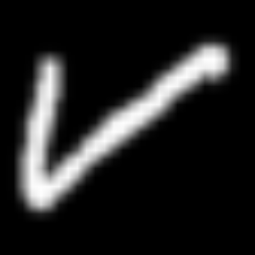

In [4]:
# This cell is for demo purposes. feel free to remove it if you want.
print('Number of classes in dataset:', len(train_data.classes))
print('Unique labels:', train_data.classes)

demo_img, demo_label = train_data[10]

print(demo_label)
torchvision.transforms.functional.resize(demo_img, (255, 255)) # handle the conversion of images to tensors

In [5]:
# Check the shape of the images and labels
print(train_data.data.shape)
print(train_data.targets.shape)
print("Number of classes: ", len(train_data.classes))

torch.Size([697932, 28, 28])
torch.Size([697932])
Number of classes:  62


In [6]:
# tran it to a vector
train_data.data = train_data.data.reshape(-1,28*28)
test_data.data = test_data.data.reshape(-1,28*28)

print(train_data.data.shape)

torch.Size([697932, 784])


# Data Preprocessing

In [7]:
# take data to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# Transformations for the EMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(), # Convert images to tensors
])

# Load the datasets
train_data = EMNIST(root='emnist_data/', split='byclass', train=True, download=True, transform=transform)
test_data = EMNIST(root='emnist_data/', split='byclass', train=False, download=True, transform=transform)

# Define the size of the subset as a fraction of the original dataset
subset_fraction = 0.1 ## You can play with this to get a bigger or smaller subset

# Create indices for the training subset
train_indices = np.random.choice(len(train_data), int(len(train_data) * subset_fraction), replace=False)

# Create the training subset
train_subset = Subset(train_data, train_indices)

# For the test set, you can do the same or use the full test set
test_indices = np.random.choice(len(test_data), int(len(test_data) * subset_fraction), replace=False)
test_subset = Subset(test_data, test_indices)

# Check the size of the subset
print(f"Training subset size: {len(train_subset)}")
print(f"Test subset size: {len(test_subset)}")

# Define the DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

Training subset size: 69793
Test subset size: 11632


# NN Model

In [9]:
 #Define the model architecture
class EMNISTClassifier(nn.Module):
    def __init__(self):
        super(EMNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(7 * 7 * 64, 128)  # Adjust the input size after max pooling
        self.fc2 = nn.Linear(128, 62)  # 62 classes in EMNIST
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 7 * 7 * 64)  # Adjust the input size after max pooling
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

# Loss Function and Optimizer

In [14]:
#Instantiate the model
model = EMNISTClassifier().to(device)

#Define the loss function (cross-entropy loss)
criterion = nn.CrossEntropyLoss()

#Define the optimizer (Adam's)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Training

In [15]:

# Set the number of epochs
num_epochs = 10

# Define lists to store loss and accuracy for plotting
train_loss = []
train_acc = []

# Set the model to training mode
model.train()

# Start training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Iterate over the training dataset in batches
    for images, labels in train_loader:
        # Move the inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_predictions / total_predictions

    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Save the loss and accuracy for plotting
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)


Epoch [1/10], Loss: 3.8272, Accuracy: 0.3337
Epoch [2/10], Loss: 3.7872, Accuracy: 0.3682
Epoch [3/10], Loss: 3.7728, Accuracy: 0.3829
Epoch [4/10], Loss: 3.7267, Accuracy: 0.4293
Epoch [5/10], Loss: 3.7031, Accuracy: 0.4524
Epoch [6/10], Loss: 3.6790, Accuracy: 0.4772
Epoch [7/10], Loss: 3.6656, Accuracy: 0.4901
Epoch [8/10], Loss: 3.6573, Accuracy: 0.4980
Epoch [9/10], Loss: 3.6454, Accuracy: 0.5101
Epoch [10/10], Loss: 3.6426, Accuracy: 0.5124


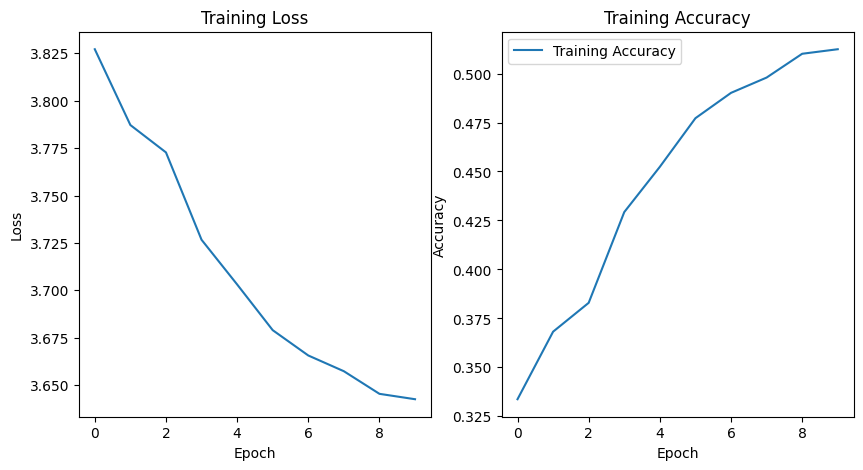

In [16]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.legend()
plt.show()
